## Key Takeaways

### For NNs using Images
- Convolutions are helpful
- SGD isn't as good as newer optimizers like Adam and NesterovAdam - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f
- normalization is helpful (both of the features and the output) and helps prevent divergence
- batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md


### Generally
- Never trust the data blindly

## Setup

### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History

from tensorflow.python.client import device_lib

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

print(device_lib.list_local_devices()) # confirm using GPU

D:\Anaconda2\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 653952035928800407
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4964850073
locality {
  bus_id: 1
}
incarnation: 1330769385192892458
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Constants

In [2]:
TRAIN_DATA = '../data/training.csv'
TEST_DATA = '../data/test.csv'
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)

### Load the Data

In [3]:
def loader(test=False, seed=None, keeplabels=None):
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    df = df.dropna() # drop rows with missing labels
    
    X = np.vstack(df['Image'])
    # by pixel across the whole dataset subtract mean and divide by stdev
    X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
    X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns.difference(['Image'])].values
        y = y.astype(np.float32)
        y = (y - 48) / 48 # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
    else:
        y = None
    
    X = X.reshape(-1, 96, 96, 1)

    return X, y, df.columns.difference(['Image'])


In [4]:
X, y, labels = loader(seed=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
data=[X_train, X_test, y_train, y_test]

In [5]:
np.min(y_train)
np.max(y_train)

0.9960205

### Plot an Example Image

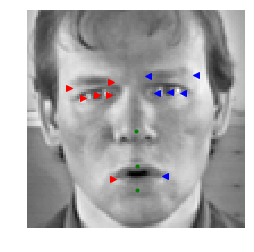

In [6]:
def plot_image(image, points, labels=list(labels), title=None):
    """Helper function to plot images"""
    plt.figure(figsize=(4,4))
    plt.imshow(np.reshape(image,(96,96)), cmap = 'gray')
    x = 0
    for i, label in enumerate(labels):
        if label[-1]=='x':
            x = points[i]
        else:
            if label in ['left_eye_center_y',
                         'left_eye_inner_corner_y', 
                         'left_eye_outer_corner_y', 
                         'left_eyebrow_inner_end_y', 
                         'left_eyebrow_outer_end_y',
                         'mouth_left_corner_y'
                        ]:
                plt.plot(x, points[i], 'b<')
            elif label in ['right_eye_center_y',
                         'right_eye_inner_corner_y', 
                         'right_eye_outer_corner_y', 
                         'right_eyebrow_inner_end_y', 
                         'right_eyebrow_outer_end_y',
                          'mouth_right_corner_y']:
                plt.plot(x, points[i], 'r>')
            else:
                plt.plot(x, points[i],'g.')
    plt.axis('off')
    if title:
        plt.title(title)



plot_image(X_train[0], 48*y_train[0]+48, labels)


### Model Fitting Function

In [7]:
def fit_model(model, data, epochs=1000, patience=100):
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    model.compile(loss='mse', optimizer=Nadam())
    earlystop = EarlyStopping(monitor='val_loss',
                             patience=patience,
                             verbose=1,
                             mode="auto")
    callbacks = [earlystop]
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=32,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test)
             )
    return history

### Helper function to plot the loss

In [8]:
def plot_loss(hists, names):
    colordict = {
        0 : 'b',
        1 : 'g',
        2 : 'r'
    }
    
    for i, hist in enumerate(hists):
        plt.plot([np.sqrt(x) * 48 for x in hist.history['loss']],
                 color=colordict[i],
                 label="train " + names[i])
        plt.plot([np.sqrt(x) * 48 for x in hist.history['val_loss']],
                 color=colordict[i],
                 linestyle=':',
                 label="valid " + names[i])
        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("RMSE")
        plt.yscale("log")
    plt.show()

## Models 
### 1 Dense Hidden Layer with 100 units

In [9]:
model1 = Sequential()
model1.add(Flatten(input_shape=INPUT_SHAPE))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(30))
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model1_hist = fit_model(model1,data,epochs=10000,patience=100)
model1.save('./saved-models/1dense100neuronlayer.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/10000
1712/1712 [==============================] - 1s 395us/step - loss: 18.6602 - val_loss: 3.0056
Epoch 2/10000
1712/1712 [==============================] - 0s 203us/step - loss: 10.2629 - val_loss: 2.7016
Epoch 3/10000
1712/1712 [==============================] - 0s 223us/step - loss: 1.5651 - val_loss: 5.5050
Epoch 4/10000
1712/1712 [==============================] - 0s 215us/step - loss: 12.5321 - val_loss: 1.7153
Epoch 5/10000
1712/1712 [==============================] - 0s 211us/step - loss: 2.3283 - val_loss: 15.9971
Epoch 6/10000
1712/1712 [==============================] - 0s 226us/step - loss: 4.2995 - val_loss: 0.8930
Epoch 7/10000
1712/1712 [==============================] - 0s 221us/step - loss: 0.4631 - val_loss: 0.4699
Epoch 8/10000
1712/1712 [==============================] - 0s 207us/step - loss: 0.8150 - val_loss: 0.4192
Epoch 9/10000
1712/1712 [==============================] - 0s 202us/step - loss: 0.3328 - val

1712/1712 [==============================] - 0s 212us/step - loss: 0.0861 - val_loss: 0.1750
Epoch 77/10000
1712/1712 [==============================] - 0s 220us/step - loss: 0.2108 - val_loss: 0.1906
Epoch 78/10000
1712/1712 [==============================] - 0s 208us/step - loss: 0.1316 - val_loss: 0.2316
Epoch 79/10000
1712/1712 [==============================] - 0s 206us/step - loss: 0.0860 - val_loss: 0.1688
Epoch 80/10000
1712/1712 [==============================] - 0s 214us/step - loss: 0.1436 - val_loss: 0.1654
Epoch 81/10000
1712/1712 [==============================] - 0s 210us/step - loss: 0.2495 - val_loss: 0.2453
Epoch 82/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0884 - val_loss: 0.2982
Epoch 83/10000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0758 - val_loss: 0.1393
Epoch 84/10000
1712/1712 [==============================] - 0s 213us/step - loss: 0.1338 - val_loss: 0.2755
Epoch 85/10000
1712/1712 [=================

1712/1712 [==============================] - 0s 201us/step - loss: 0.0448 - val_loss: 0.0478
Epoch 152/10000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0352 - val_loss: 0.0582
Epoch 153/10000
1712/1712 [==============================] - 0s 204us/step - loss: 0.0364 - val_loss: 0.0493
Epoch 154/10000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0173 - val_loss: 0.0873
Epoch 00154: early stopping


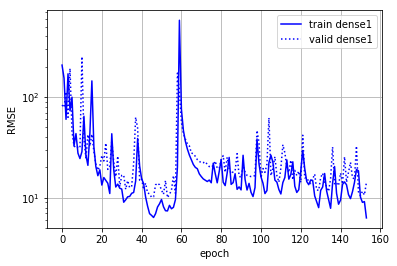

In [11]:
plot_loss([model1_hist],['dense1'])

In [12]:
model1BN = Sequential()
model1BN.add(Flatten(input_shape=INPUT_SHAPE))
model1BN.add(Dense(100, activation='relu'))
model1BN.add(BatchNormalization())
model1BN.add(Dense(30))
print(model1BN.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               921700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 925,130
Trainable params: 924,930
Non-trainable params: 200
_________________________________________________________________
None


In [13]:
model1BN_hist = fit_model(model1BN,data,epochs=10000,patience=100)
model1BN.save('./saved-models/1dense100neuronlayer_wbatchnormalization.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/10000
1712/1712 [==============================] - 1s 433us/step - loss: 0.2608 - val_loss: 0.0474
Epoch 2/10000
1712/1712 [==============================] - 0s 292us/step - loss: 0.0146 - val_loss: 0.0158
Epoch 3/10000
1712/1712 [==============================] - 0s 268us/step - loss: 0.0056 - val_loss: 0.0073
Epoch 4/10000
1712/1712 [==============================] - 0s 260us/step - loss: 0.0045 - val_loss: 0.0063
Epoch 5/10000
1712/1712 [==============================] - 0s 261us/step - loss: 0.0036 - val_loss: 0.0050
Epoch 6/10000
1712/1712 [==============================] - 1s 307us/step - loss: 0.0035 - val_loss: 0.0039
Epoch 7/10000
1712/1712 [==============================] - 0s 264us/step - loss: 0.0033 - val_loss: 0.0051
Epoch 8/10000
1712/1712 [==============================] - 0s 260us/step - loss: 0.0034 - val_loss: 0.0047
Epoch 9/10000
1712/1712 [==============================] - 0s 275us/step - loss: 0.0032 - val_los

1712/1712 [==============================] - 0s 260us/step - loss: 0.0017 - val_loss: 0.0032
Epoch 77/10000
1712/1712 [==============================] - 0s 272us/step - loss: 0.0016 - val_loss: 0.0032
Epoch 78/10000
1712/1712 [==============================] - 0s 268us/step - loss: 0.0015 - val_loss: 0.0040
Epoch 79/10000
1712/1712 [==============================] - 0s 264us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 80/10000
1712/1712 [==============================] - 1s 316us/step - loss: 0.0017 - val_loss: 0.0032
Epoch 81/10000
1712/1712 [==============================] - 0s 271us/step - loss: 0.0016 - val_loss: 0.0045
Epoch 82/10000
1712/1712 [==============================] - 0s 284us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 83/10000
1712/1712 [==============================] - 0s 275us/step - loss: 0.0015 - val_loss: 0.0032
Epoch 84/10000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0018 - val_loss: 0.0029
Epoch 85/10000
1712/1712 [=================

1712/1712 [==============================] - 0s 292us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 152/10000
1712/1712 [==============================] - 1s 312us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 153/10000
1712/1712 [==============================] - 0s 257us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 154/10000
1712/1712 [==============================] - 1s 303us/step - loss: 0.0012 - val_loss: 0.0043
Epoch 155/10000
1712/1712 [==============================] - 0s 270us/step - loss: 0.0011 - val_loss: 0.0025
Epoch 156/10000
1712/1712 [==============================] - 0s 250us/step - loss: 0.0012 - val_loss: 0.0026
Epoch 157/10000
1712/1712 [==============================] - 0s 287us/step - loss: 0.0010 - val_loss: 0.0065
Epoch 158/10000
1712/1712 [==============================] - 0s 266us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 159/10000
1712/1712 [==============================] - 0s 248us/step - loss: 0.0012 - val_loss: 0.0033
Epoch 160/10000
1712/1712 [========

1712/1712 [==============================] - 0s 264us/step - loss: 9.8462e-04 - val_loss: 0.0024
Epoch 226/10000
1712/1712 [==============================] - 0s 272us/step - loss: 9.2558e-04 - val_loss: 0.0028
Epoch 227/10000
1712/1712 [==============================] - 0s 291us/step - loss: 9.0790e-04 - val_loss: 0.0028
Epoch 228/10000
1712/1712 [==============================] - 1s 294us/step - loss: 9.2099e-04 - val_loss: 0.0026
Epoch 229/10000
1712/1712 [==============================] - 0s 284us/step - loss: 9.4145e-04 - val_loss: 0.0023
Epoch 230/10000
1712/1712 [==============================] - 0s 265us/step - loss: 8.6172e-04 - val_loss: 0.0027
Epoch 231/10000
1712/1712 [==============================] - 0s 242us/step - loss: 9.0700e-04 - val_loss: 0.0026
Epoch 00231: early stopping


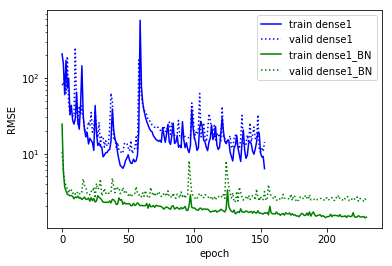

In [14]:
plot_loss([model1_hist,model1BN_hist],['dense1','dense1_BN'])

### Model with convolutions

In [15]:
model2 = Sequential()
model2.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(500, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(100, activation = "relu"))
model2.add(BatchNormalization())
model2.add(Dense(30))
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       32896     
__________

In [16]:
model2_hist = fit_model(model2,data,epochs=10000,patience=100)
model2.save('./saved-models/CNN.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/10000
1712/1712 [==============================] - 4s 2ms/step - loss: 0.2517 - val_loss: 0.0912
Epoch 2/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0179 - val_loss: 0.0320
Epoch 3/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 4/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 5/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 6/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 7/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 8/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 9/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0081
Epoch 10

Epoch 78/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 79/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 80/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 81/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 82/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 83/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 84/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 85/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 86/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 87/10000
1712/1712 [====================

Epoch 153/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 7.6638e-04 - val_loss: 0.0018
Epoch 154/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 7.1808e-04 - val_loss: 0.0013
Epoch 155/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 7.6550e-04 - val_loss: 0.0013
Epoch 156/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 6.7525e-04 - val_loss: 0.0015
Epoch 157/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 6.9782e-04 - val_loss: 0.0016
Epoch 158/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.6301e-04 - val_loss: 0.0023
Epoch 159/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 7.7183e-04 - val_loss: 0.0019
Epoch 160/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 6.6957e-04 - val_loss: 0.0018
Epoch 161/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 6.5686e-04 - val_loss: 0.0014
E

Epoch 227/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.2678e-04 - val_loss: 0.0015
Epoch 228/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.7588e-04 - val_loss: 0.0013
Epoch 229/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.5049e-04 - val_loss: 0.0011
Epoch 230/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.1750e-04 - val_loss: 0.0011
Epoch 231/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.1801e-04 - val_loss: 0.0013
Epoch 232/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.3822e-04 - val_loss: 0.0011
Epoch 233/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 5.1104e-04 - val_loss: 0.0011
Epoch 234/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.8199e-04 - val_loss: 0.0013
Epoch 235/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 5.1561e-04 - val_loss: 0.0014
E

Epoch 301/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.2604e-04 - val_loss: 0.0014
Epoch 302/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 4.6056e-04 - val_loss: 0.0010
Epoch 303/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.4080e-04 - val_loss: 0.0011
Epoch 304/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.1308e-04 - val_loss: 0.0010
Epoch 305/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.0012e-04 - val_loss: 0.0010
Epoch 306/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.8345e-04 - val_loss: 0.0012
Epoch 307/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.2571e-04 - val_loss: 0.0012
Epoch 308/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.3251e-04 - val_loss: 0.0012
Epoch 309/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 4.3021e-04 - val_loss: 0.0012
E

1712/1712 [==============================] - 3s 1ms/step - loss: 3.5541e-04 - val_loss: 0.0011
Epoch 375/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.9931e-04 - val_loss: 0.0011
Epoch 376/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.4859e-04 - val_loss: 9.9931e-04
Epoch 377/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.5200e-04 - val_loss: 0.0010
Epoch 378/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.4333e-04 - val_loss: 0.0010
Epoch 379/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.5452e-04 - val_loss: 0.0010
Epoch 380/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3189e-04 - val_loss: 9.4840e-04
Epoch 381/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.3750e-04 - val_loss: 9.6982e-04
Epoch 382/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.4800e-04 - val_loss: 0.0013
Epoch

1712/1712 [==============================] - 3s 2ms/step - loss: 2.9267e-04 - val_loss: 9.8647e-04
Epoch 448/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.9468e-04 - val_loss: 9.9066e-04
Epoch 449/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.1036e-04 - val_loss: 9.9428e-04
Epoch 450/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.1797e-04 - val_loss: 9.2240e-04
Epoch 451/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.1563e-04 - val_loss: 9.3313e-04
Epoch 452/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0959e-04 - val_loss: 0.0011
Epoch 453/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 3.1535e-04 - val_loss: 9.9734e-04
Epoch 454/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0229e-04 - val_loss: 9.6753e-04
Epoch 455/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9895e-04 - val_lo

1712/1712 [==============================] - 3s 2ms/step - loss: 2.6751e-04 - val_loss: 9.6195e-04
Epoch 520/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.8789e-04 - val_loss: 9.4109e-04
Epoch 521/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0993e-04 - val_loss: 0.0011
Epoch 522/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.7688e-04 - val_loss: 0.0010
Epoch 523/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.7974e-04 - val_loss: 9.6843e-04
Epoch 524/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8219e-04 - val_loss: 9.8141e-04
Epoch 525/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 3.0210e-04 - val_loss: 9.7121e-04
Epoch 526/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.9686e-04 - val_loss: 0.0010
Epoch 527/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8522e-04 - val_loss: 9.23

Epoch 591/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.5832e-04 - val_loss: 9.0505e-04
Epoch 592/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.6365e-04 - val_loss: 9.2793e-04
Epoch 593/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6849e-04 - val_loss: 9.5949e-04
Epoch 594/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.9294e-04 - val_loss: 9.8240e-04
Epoch 595/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.6399e-04 - val_loss: 9.1504e-04
Epoch 596/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.8581e-04 - val_loss: 8.8382e-04
Epoch 597/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.4931e-04 - val_loss: 0.0011
Epoch 598/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.8358e-04 - val_loss: 9.2500e-04
Epoch 599/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.9

1712/1712 [==============================] - 3s 1ms/step - loss: 2.6792e-04 - val_loss: 8.8175e-04
Epoch 663/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1991e-04 - val_loss: 9.0595e-04
Epoch 664/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.7086e-04 - val_loss: 9.2239e-04
Epoch 665/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.4961e-04 - val_loss: 9.3733e-04
Epoch 666/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.3529e-04 - val_loss: 9.1390e-04
Epoch 667/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.5624e-04 - val_loss: 9.2760e-04
Epoch 668/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.4888e-04 - val_loss: 9.2107e-04
Epoch 669/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.4161e-04 - val_loss: 9.7054e-04
Epoch 670/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.7280e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.2791e-04 - val_loss: 8.8536e-04
Epoch 734/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5001e-04 - val_loss: 9.0432e-04
Epoch 735/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2974e-04 - val_loss: 9.1992e-04
Epoch 736/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3596e-04 - val_loss: 9.3358e-04
Epoch 737/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5158e-04 - val_loss: 8.9640e-04
Epoch 738/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.5521e-04 - val_loss: 9.0433e-04
Epoch 739/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.7272e-04 - val_loss: 8.8776e-04
Epoch 740/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.3807e-04 - val_loss: 8.9235e-04
Epoch 741/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.5107e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.3047e-04 - val_loss: 9.1584e-04
Epoch 805/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.2590e-04 - val_loss: 9.0330e-04
Epoch 806/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.4848e-04 - val_loss: 8.8073e-04
Epoch 807/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.0421e-04 - val_loss: 9.2395e-04
Epoch 808/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2370e-04 - val_loss: 9.3156e-04
Epoch 809/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3538e-04 - val_loss: 8.9387e-04
Epoch 810/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3433e-04 - val_loss: 9.1488e-04
Epoch 811/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.3775e-04 - val_loss: 8.9209e-04
Epoch 812/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.4044e-04 - va

1712/1712 [==============================] - 3s 2ms/step - loss: 2.0601e-04 - val_loss: 8.9780e-04
Epoch 876/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1990e-04 - val_loss: 9.2179e-04
Epoch 877/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.1960e-04 - val_loss: 8.8195e-04
Epoch 878/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.2139e-04 - val_loss: 9.4795e-04
Epoch 879/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1735e-04 - val_loss: 9.1939e-04
Epoch 880/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.1653e-04 - val_loss: 8.9258e-04
Epoch 881/10000
1712/1712 [==============================] - 3s 2ms/step - loss: 2.3548e-04 - val_loss: 9.1372e-04
Epoch 882/10000
1712/1712 [==============================] - 3s 1ms/step - loss: 2.2271e-04 - val_loss: 9.4735e-04
Epoch 00882: early stopping


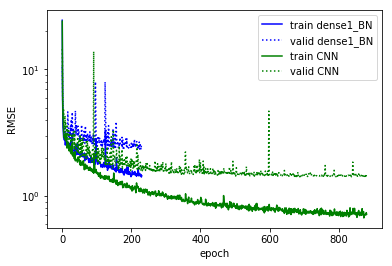

In [17]:
plot_loss([model1BN_hist, model2_hist],['dense1_BN','CNN'])

### Use the custom generator to enhance the training data

In [18]:
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X_train,y_train,whichlabels=list(labels), batch_size=32)
def fit_model_gen(model, generator=datagen, data=data, epochs=100, patience=10):
    X_valid = data[1]
    y_valid = data[3]
    model.compile(loss='mse', optimizer=Nadam())
    earlystop = EarlyStopping(monitor='val_loss',
                             patience=patience,
                             verbose=1,
                             mode="auto")
    callbacks = [earlystop]
    history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=(X_valid, y_valid)
             )
    return history

In [19]:
# basically a copy of model 2, but will train with augmented data
model2_augmented = Sequential()
model2_augmented.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model2_augmented.add(BatchNormalization())
model2_augmented.add(MaxPooling2D(pool_size=(2, 2)))
model2_augmented.add(Flatten())
model2_augmented.add(Dense(500, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(100, activation = "relu"))
model2_augmented.add(BatchNormalization())
model2_augmented.add(Dense(30))
print(model2_augmented.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 128)       32896     
__________

In [20]:
model2_augmented_hist = fit_model_gen(model2_augmented,datagen, data,epochs=10000,patience=100)
model2_augmented.save('./saved-models/CNN_augmented.h5')

Epoch 1/10000
53/53 [==============================] - 4s 66ms/step - loss: 0.2328 - val_loss: 0.1021
Epoch 2/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0155 - val_loss: 0.0282
Epoch 3/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0086 - val_loss: 0.0117
Epoch 4/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 5/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 6/10000
53/53 [==============================] - 2s 47ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 7/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 9/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 10/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.004

53/53 [==============================] - 3s 50ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 81/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 82/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 83/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 84/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 85/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 86/10000
53/53 [==============================] - 3s 47ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 87/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 88/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 89/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0018 - va

53/53 [==============================] - 3s 50ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 160/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 161/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 162/10000
53/53 [==============================] - 3s 47ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 163/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 164/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 165/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 166/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 167/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 168/10000
53/53 [==============================] - 3s 48ms/step - loss: 0.

Epoch 238/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 239/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 240/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 241/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 242/10000
53/53 [==============================] - 3s 49ms/step - loss: 0.0010 - val_loss: 9.9407e-04
Epoch 243/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 244/10000
53/53 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 245/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 246/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 247/10000
53/53 [==============================] - 3s 

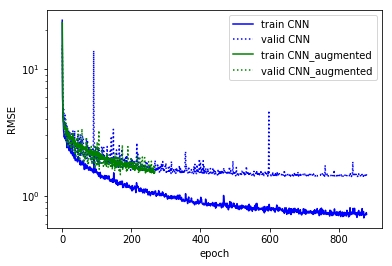

In [21]:
plot_loss([model2_hist, model2_augmented_hist],['CNN','CNN_augmented'])

The augmented data improves the validation RMSE by adding some variance to the training data.

In [22]:
### Add Dropout to avoid over-fitting and up the last hidden level

In [34]:
model3 = Sequential()
model3.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                input_shape=INPUT_SHAPE))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.1))
model3.add(Conv2D(filters=64,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.2))
model3.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(.3))
model3.add(Flatten())
model3.add(Dense(500, activation = "relu"))
model3.add(Dropout(.5))
model3.add(BatchNormalization())
model3.add(Dense(500, activation = "relu"))
model3.add(BatchNormalization())
model3.add(Dense(30))
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        8256      
_________________________________________________________________
batch_normalization_18 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)        0         
__________

In [24]:
model3_hist = fit_model_gen(model3,datagen, data,epochs=10000,patience=100)
model3.save('./saved-models/CNN_aug_dropout.h5')

Epoch 1/10000
53/53 [==============================] - 4s 73ms/step - loss: 0.6750 - val_loss: 0.2894
Epoch 2/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.1153 - val_loss: 0.1826
Epoch 3/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0698 - val_loss: 0.4425
Epoch 4/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0580 - val_loss: 0.6386
Epoch 5/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0451 - val_loss: 0.3835
Epoch 6/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0422 - val_loss: 0.5925
Epoch 7/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0403 - val_loss: 1.0929
Epoch 8/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0379 - val_loss: 0.2985
Epoch 9/10000
53/53 [==============================] - 3s 54ms/step - loss: 0.0325 - val_loss: 0.3874
Epoch 10/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.034

53/53 [==============================] - 3s 52ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 81/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0086 - val_loss: 0.0163
Epoch 82/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 83/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 84/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0069 - val_loss: 0.0035
Epoch 85/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 86/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0093 - val_loss: 0.0238
Epoch 87/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0063 - val_loss: 0.0256
Epoch 88/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 89/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0069 - va

53/53 [==============================] - 3s 51ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 160/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0036 - val_loss: 0.0121
Epoch 161/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 162/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0032 - val_loss: 0.1714
Epoch 163/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 164/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 165/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 166/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 167/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 168/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.

Epoch 238/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 239/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 240/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 241/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 242/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 243/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 244/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 245/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 246/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 247/10000
53/53 [==============================] - 3s 52ms

53/53 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 0.1819
Epoch 316/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 317/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0018 - val_loss: 9.5857e-04
Epoch 318/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0017 - val_loss: 9.8391e-04
Epoch 319/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 8.8690e-04
Epoch 320/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 321/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 9.1965e-04
Epoch 322/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0016 - val_loss: 9.2663e-04
Epoch 323/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 8.5950e-04
Epoch 324/10000
53/53 [==============================] -

53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.3130e-04
Epoch 392/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.1348e-04
Epoch 393/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.7991e-04
Epoch 394/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 7.6731e-04
Epoch 395/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.7005e-04
Epoch 396/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.7843e-04
Epoch 397/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 398/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0016 - val_loss: 8.9429e-04
Epoch 399/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0015 - val_loss: 8.2937e-04
Epoch 400/10000
53/53 [=========================

53/53 [==============================] - 3s 53ms/step - loss: 0.0014 - val_loss: 7.2951e-04
Epoch 468/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 7.3360e-04
Epoch 469/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0014 - val_loss: 7.1563e-04
Epoch 470/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0013 - val_loss: 7.5285e-04
Epoch 471/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0015 - val_loss: 1.2697
Epoch 472/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0016 - val_loss: 0.0070
Epoch 473/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0014 - val_loss: 8.4949e-04
Epoch 474/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0014 - val_loss: 7.8214e-04
Epoch 475/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 476/10000
53/53 [==============================] -

53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 6.8110e-04
Epoch 544/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 7.1079e-04
Epoch 545/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.7900e-04
Epoch 546/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 7.1155e-04
Epoch 547/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 7.4462e-04
Epoch 548/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 0.3798
Epoch 549/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0013 - val_loss: 7.5513e-04
Epoch 550/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0013 - val_loss: 7.5365e-04
Epoch 551/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.7631e-04
Epoch 552/10000
53/53 [=========================

53/53 [==============================] - 3s 53ms/step - loss: 0.0012 - val_loss: 7.0347e-04
Epoch 620/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.9439e-04
Epoch 621/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.7184e-04
Epoch 622/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 7.2006e-04
Epoch 623/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 8.9688e-04
Epoch 624/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0013 - val_loss: 7.1090e-04
Epoch 625/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.8232e-04
Epoch 626/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 7.2336e-04
Epoch 627/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 628/10000
53/53 [=========================

53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.9834e-04
Epoch 696/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.7051e-04
Epoch 697/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.5961e-04
Epoch 698/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.4680e-04
Epoch 699/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 7.3022e-04
Epoch 700/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 701/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.7288e-04
Epoch 702/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 6.5714e-04
Epoch 703/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0012 - val_loss: 7.2907e-04
Epoch 704/10000
53/53 [=========================

53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 772/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 6.3466e-04
Epoch 773/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.8722e-04
Epoch 774/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 8.0825e-04
Epoch 775/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.6863e-04
Epoch 776/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.4533e-04
Epoch 777/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.0867e-04
Epoch 778/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.9309e-04
Epoch 779/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 7.7677e-04
Epoch 780/10000
53/53 [=========================

53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.9293e-04
Epoch 848/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.7152e-04
Epoch 849/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.8341e-04
Epoch 850/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.2557e-04
Epoch 851/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.6842e-04
Epoch 852/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.8702e-04
Epoch 853/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.6161e-04
Epoch 854/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 6.9056e-04
Epoch 855/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.4552e-04
Epoch 856/10000
53/53 [=====================

53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 6.4401e-04
Epoch 924/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.6428e-04
Epoch 925/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 6.4967e-04
Epoch 926/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 6.4980e-04
Epoch 927/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 7.2136e-04
Epoch 928/10000
53/53 [==============================] - 3s 50ms/step - loss: 0.0011 - val_loss: 6.6191e-04
Epoch 929/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0012 - val_loss: 6.7649e-04
Epoch 930/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 6.6175e-04
Epoch 931/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 6.1918e-04
Epoch 932/10000
53/53 [=====================

53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 1000/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.0449
Epoch 1001/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.1611
Epoch 1002/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0011 - val_loss: 0.2451
Epoch 1003/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.3056
Epoch 1004/10000
53/53 [==============================] - 3s 51ms/step - loss: 0.0011 - val_loss: 0.4757
Epoch 1005/10000
53/53 [==============================] - 3s 53ms/step - loss: 0.0011 - val_loss: 0.5880
Epoch 1006/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 0.5825
Epoch 1007/10000
53/53 [==============================] - 3s 52ms/step - loss: 0.0010 - val_loss: 0.3479
Epoch 1008/10000
53/53 [==============================] - 3s 51ms/step -

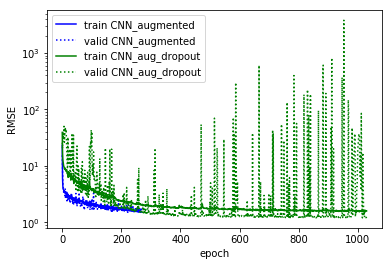

In [25]:
plot_loss([model2_augmented_hist, model3_hist],['CNN_augmented','CNN_aug_dropout'])

## Create Predictions
### Load the Testing Time Images

In [26]:
out_images, _ , _ = loader(test=True, seed=None, keeplabels=None)

### Create the Preditions

In [27]:
final_model = model2
prediction = final_model.predict(out_images)

### Plot some example predictions

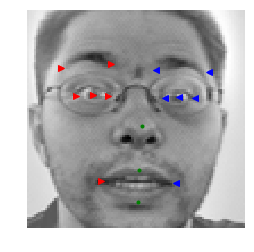

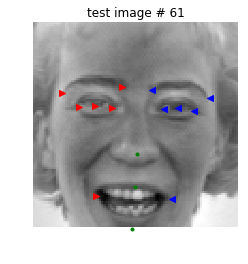

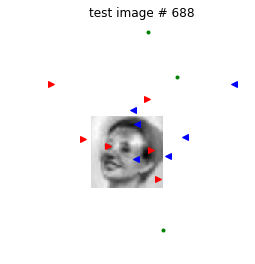

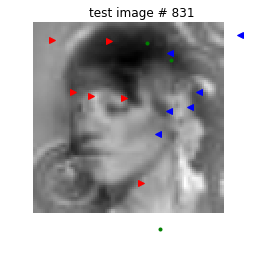

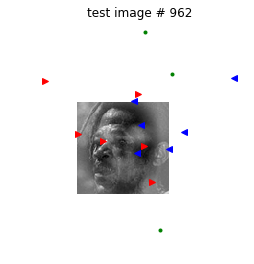

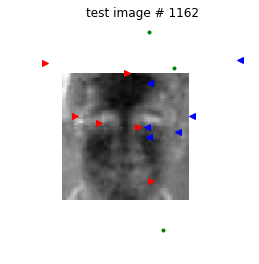

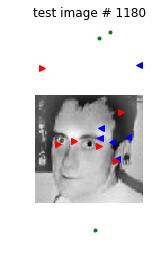

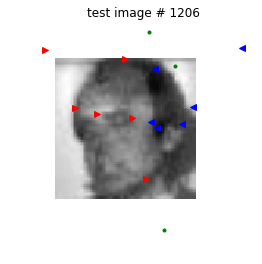

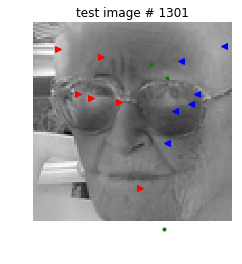

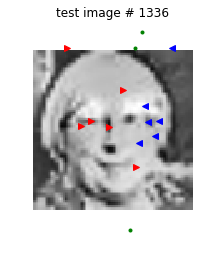

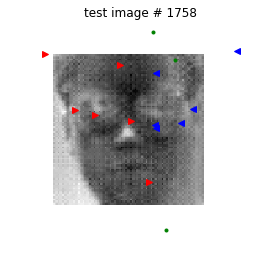

In [28]:
# first image
plot_image(out_images[0], 48*prediction[0]+48, labels)



# images that have labels outside the image
for i in np.where(np.max(np.abs(prediction),axis=1)>1)[0]:
    plot_image(out_images[i],
        48*prediction[i]+48, labels,title='test image # ' + str(i))




### Put the predictions into the submission format

In [29]:
IdLookupTable = read_csv('../data/IdLookupTable.csv')
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [30]:
label_locs = {}
for i, label in enumerate(labels):
    label_locs[label]=i

IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs)
IdLookupTable['Location'] = (48*prediction[IdLookupTable['ImageId']-1,
                                       IdLookupTable['test']]) + 48

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location,test
0,1,1,left_eye_center_x,66.801460,0
1,2,1,left_eye_center_y,37.563599,1
2,3,1,right_eye_center_x,28.745617,20
3,4,1,right_eye_center_y,36.957924,21
4,5,1,left_eye_inner_corner_x,60.363380,2


In [31]:
Submission = IdLookupTable[['RowId','Location']]
Submission.head()

,RowId,Location
0,1,66.801460
1,2,37.563599
2,3,28.745617
3,4,36.957924
4,5,60.363380


In [32]:
Submission.to_csv(path_or_buf='./Submissions/CNN_wdatAugment.csv',
                  index=False)

In [33]:
Submission.describe()

,RowId,Location
count,27124.000000,27124.000000
mean,13562.500000,48.609348
std,7830.168687,18.121922
min,1.000000,0.000000
25%,6781.750000,35.262190
50%,13562.500000,45.730776
75%,20343.250000,63.306358
max,27124.000000,96.000000
